# 2.2.3 Inducción de reglas con el algoritmo Apriori

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

Una de las aplicaciones directas del concepto de probabilidad como frecuencia es la construcción de sistemas de recomendación basados en que ítems siempre van juntos. Este tipo de sistema de recomendación es diferente de aquellos que buscan clientes con comportamientos similares para realizar la recomendación de productos. En términos más generales, este tipo de sistemas permite obtener los conjuntos de ítems que los clientes suelen seleccionar. En este tutorial se discute el algoritmo Apriori para la construcción de reglas de asociación entre ítems.

### Descripción del problema

Un problema típico de los retailers es poder recomendar productos afines a sus compradores basados en el histórico general de las ventas. Estas recomendaciones tienen como fin sugerirle al usuario productos que podría haber olvidado y que usualmente se llevan juntos, o nuevos productos sustitutos que reemplazarían productos ya posicionados. Esta recomendación se basa en el histórico general de la tienda (productos que todas las personas usualmente llevan juntos) y no en las preferencias individuales de los clientes.

Para ejemplificar el proceso de construcción de las reglas de inducción, se tiene un conjunto ficticio de 10 transacciones realizadas sobre seis posibles ítems (x1,...,x6), donde cada fila representa una transacción:

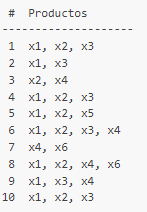

El problema consiste en derivar un conjunto de reglas de asociación que permita recomenda un grupo de productos a partir de los productos que ya seleccionó el cliente. Por ejemplo, si un cliente compra x1 y x3, ¿qué producto o productos se le deben recomendar?

### Transacción

Una transacción se representa a través del conjunto de ítems comprados en ella. Así, una transacción con cuatro ítems se representa como:
    
{x1,x2,x3,x4}

El problema descrito equivale a determinar los productos xi, con xi∉{x1,x2,x3,x4}, con mayor probabilidad de ser comprados sabiendo que el cliente ya seleccionó x1, x2, x3 y x4. Dicho de otra forma, se deben computar las probabilidades condicionales Pr(xi|x1,x2,x3,x4) y recomendar los N productos xi con mayor probabilidad condicional de compra. En este problema se asume que SI existe una dependencia entre la compra de un producto y otro; si esta dependencia no existe, no tiene sentido construir el sistema de recomendación.

### Regla de asociación

De esta forma, el objetivo del sistema de recomendación es construir una regla de asociación de la forma:

{x2,x3,x4}→x1 

la cual indica que cuando se compran x2, x3 y x4 también se compra (implica) x1.

Es posible evaluar todas las posibles reglas por fuerza bruta (enumeración). Para el caso anterior, las reglas podrían ser: 

{x2}→x1, {x3}→x1, {x4}→x1, {x1}→x2, {x3}→x2, …, {x2,x3}→x1, ..., {x1,x2}→x4

y así sucesivamente, hasta construir todas las permutaciones posibles. Sin embargo, esta solución resulta imposible en términos prácticos debido a que la cantidad de reglas crece exponencialmente.

### Algoritmo Apriori

El algoritmo Apriori se basa en evaluar solamente las reglas que tienen una frecuencia alta (mayor probabilidad). El algoritmo se basa en la siguiente heurística: para que el conjunto {x1,x2} sea frecuente (que tenga una probabilidad alta), los ítems x1 y x2 deben ser frecuentes; es decir, si x1 o x2 son infrecuentes, su combinación no es evaluada.

Para medir la importancia de una regla se usa el soporte y la confianza. Si una regla de asocación se escribe como

X→Y

el soporte es la proporción de veces que X aparece respecto al total de transacciones; nótese que acá se está hablando explícitamente de probabilidad.

La confianza se define como:

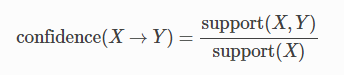

la cual se interpreta como la cantidad de veces en que la presencia de X resulta en la presencia de Y. Es decir, ya que se dio X que tan probable es que se de Y.

El algoritmo Apriori opera en dos fases: En la primera fase se identifican todos los conjuntos de ítems que cumplen con el soporte mínimo requerido (o probabilidad mínima de compra). En la segunda fase, con los ítems identificados en la fase uno, se crean reglas que cumplen con la confianza mínima requerida.

En la primera fase, se procede de forma constructiva de la siguiente forma (explícitamente se está calculado probabilidad):

- Se calcula el soporte de cada ítem y se seleccionan aquellos ítems que cumplen con el soporte mínimo requerido.

- Se forman todos las conjuntos (combinaciones) de dos ítems. Sólo se consideran combinaciones de dos ítems que contengan ítems que cumplen el soporte mínimo requerido. Se seleccionan aquellas combinaciones de dos ítems que cumplen con el soporte mínimo requerido.

- Se forman todos los conjuntos de tres ítems. No se consideran combinaciones que contengan conjuntos no frecuentes de dos ítems. Es decir, si la combinación {x1, x4} no se frecuente (no cumple con el soporte mínimo requerido), entonces no se consideran combinaciones como {x1, x3, x4} o {x1, x2, x4}.

- Se continua con las combinaciones de cuatro ítems y se seleccionan aquellas que cumplan con el soporte mínimo requerido. El algoritmo se detiene cuando ya no hay combinaciones de ítems que cumpan con el soporte mínimo.

En la segunda fase, para todas las combinaciones de 2, 3, … ítems, se generan todas las reglas posibles y se evalúa su confianza. Se seleccionan aquellas que cumplen con la confianza mínima requerida. Si la combinación {x1, x2} cumplio con el soporte mínimo, entonces se consideran las reglas {x1} → {x2} y {x2} → {x1}. Nótese que es posible considerar reglas con varios elementos en el consecuente como por ejemplo {x1} → {x2, x3}.

El lift de una regla mide la importancia de una regla en relación a la tasa típica de compra, dado que se sabe que un ítem o un conjunto de ítems han sido comprados.

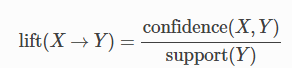

### Solución usando el lenguaje R

A continuación se describen las funcionalidades del paquete arules del lenguaje R para la construcción de reglas de asociación.

Notas: se usa r en colab -> se debe instalar r en pc para usarlo y omitir algunos codigos

In [ ]:
##
## Preparación. Se utiliza el paquete rpy2
## para ejecutar código R dentro de Python.
##
%load_ext rpy2.ipython

In [ ]:
%%sh
if /usr/bin/test ! -d /usr/local/lib/R/site-library/arules;
then
    sudo Rscript -e 'install.packages("arules")'
fi

### Preparación

In [ ]:
%%R
## Se carga la librería
library(arules)

### Formato del archivo de datos

In [ ]:
%%writefile data.csv
x1,x2,x3
x1,x3
x2,x4
x1,x2,x3
x1,x2,x5
x1,x2,x3,x4
x4,x6
x1,x2,x4,x6
x1,x3,x4
x1,x2,x3

### Lectura de las transacciones

In [ ]:
%%R
##
## Se leen los datos
##
transactions <- read.transactions("data.csv", sep = ",")

In [ ]:
%%R
##
## Se imprimen los items por transacción
##
inspect(transactions)

### Análisis exploratorio

In [ ]:
%%R
##
## Se obtiene la información más relevante de los datos:
##
##    * Número de transacciones
##    * Número total de ítems
##    * Número de transacciones por cantidad de ítems (y cuartiles)
##
summary(transactions)

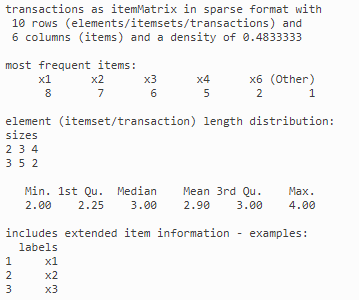

In [ ]:
%%R
##
## Se imprime la frequencia de compra, es decir,
## la frecuencia de cada ítem en el total de trasacciones
##
itemFrequency(transactions)

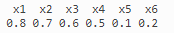

In [ ]:
%%R
##
## Se grafica un histograma que muestra la frecuencia
## con que se compraron ciertos items. El parámetro
## `support`  corresponde a la frecuencia mínima que
## deben tener un item para que sea incluído en la gráfica.
## En este caso un item debe aparecer en 0.2 * 10 = 2
## transacciones para ser tenido en cuenta. Nóte que no
## aparece x5.
##
options(repr.plot.width = 3, repr.plot.height = 2)
itemFrequencyPlot(transactions, support = 0.2)

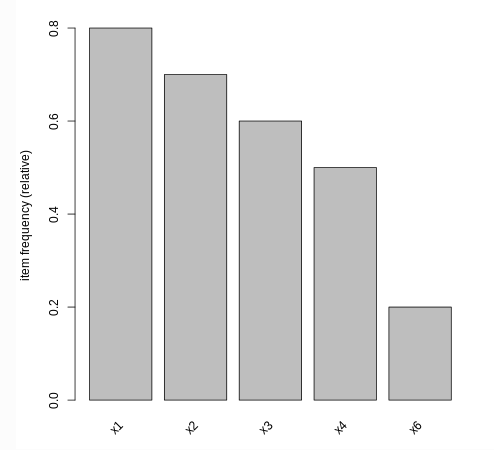

In [ ]:
%%R
##
## Se obtiene la misma gráfica anterior
## pero para los ítems más comprados.
## La gráfica muestra que x1 es el más comprado
## y x5 el menos comprado
##
options(repr.plot.width = 3, repr.plot.height = 2)
itemFrequencyPlot(transactions, topN = 6)

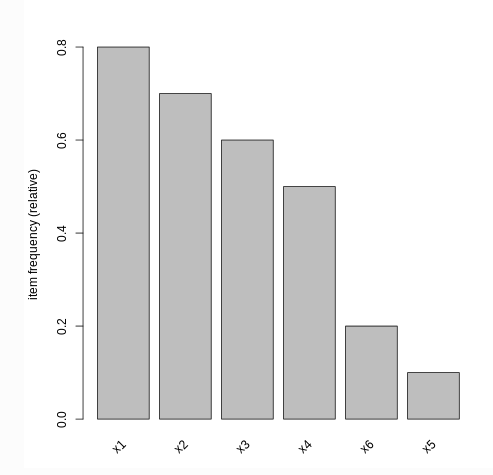

### Construcción del sistema de reglas de asociación

In [ ]:
%%R
##
## La corrida con los parámetros por defecto de la
## función no generan reglas para los datos suministrados.
## El valor por defecto de support es 0.1, es decir,
## un item debe aparecer en un mínimo de 1 transacciones
## para ser considerado.
##
apriori(transactions)

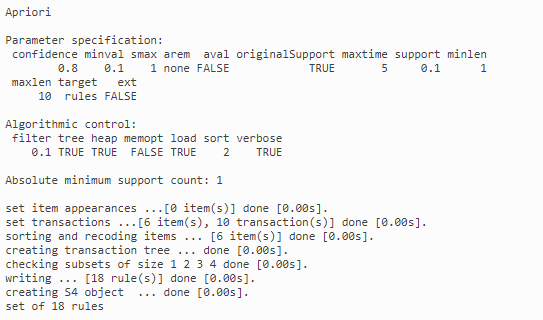

In [ ]:
%%R
##
## El parámetro confianza representa el porcentaje mínimo
## de veces que una regla debe ser correcta para que
## sea considerada; esto permite eliminar reglas sin
## sentido. El parámetro minlen indica que las reglas
## deben contener al menos 2 items.
##
transactionsrules <- apriori(transactions,
                        parameter = list(support = 0.006,
                                         confidence = 0.25,
                                         minlen = 2))

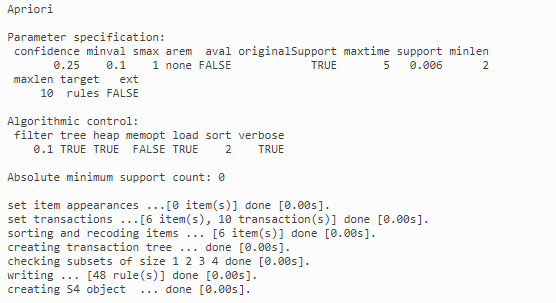

In [ ]:
%%R
##
## Número de reglas generadas.
## Se generaron 48 reglas
##
transactionsrules

In [ ]:
%%R
##
## Se imprime un resumen de las reglas generadas.
##
##   * Hay 18 reglas con 2 ítems, 22 reglas con 3 ítems
##     y así sucesivamente.
##
##   * Luego se imprimen los estadísticos para la cantidad
##     de reglas por ítem
##
##   * Seguidamente aparece el resumen de las métricas de
##     las reglas de asociación
##
summary(transactionsrules)

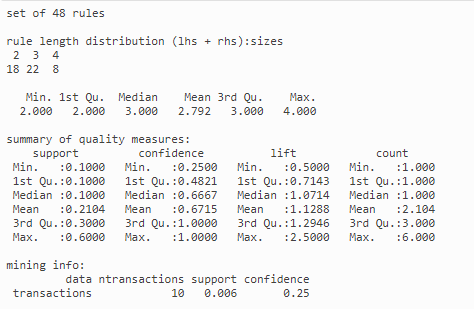

In [ ]:
%%R
##
## Visualización de todas las reglas.
##
inspect(transactionsrules)

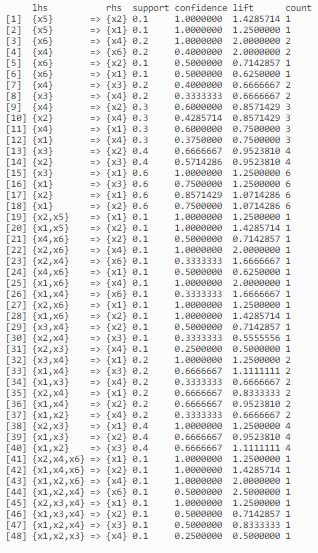

In [ ]:
%%R
##
## Se puede inspeccionar un conjunto de reglas en particular
##
inspect(sort(transactionsrules, by = "lift")[1:5])

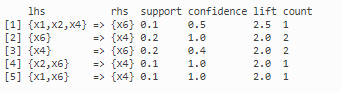

In [ ]:
%%R
##
## Se puede obtener un subconjunto de las reglas que
## cumplen una condición particular
##
berryrules <- subset(transactionsrules, items %in% "x2")
inspect(transactionsrules)

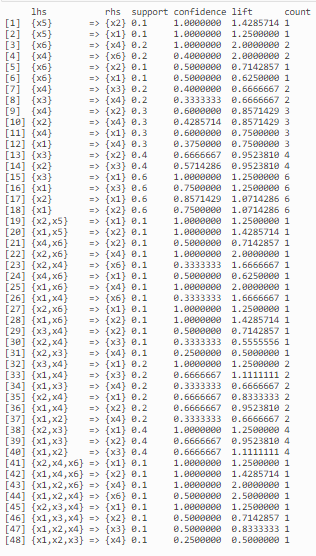

In [ ]:
!rm data.csv

### Actividades

Actividad 1.— ¿Cuántas reglas posibles hay para el caso anterior?

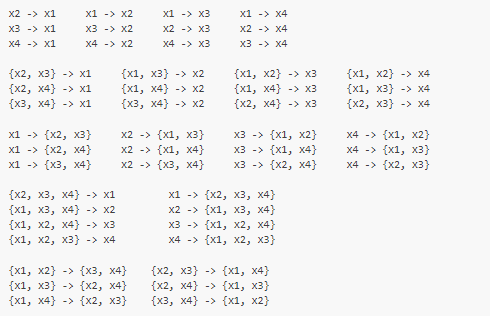

Actividad 2.— Calcule el soporte para x1 , …, x6, esto es, la probabilidad de que xi aparezca en una transacción. Si el soporte mínimo requerido es del 40%, ¿cuáles ítems debe seleccionarse?

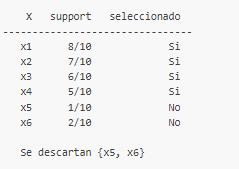

Actividad 3.— Cuáles las combinaciones de dos ítems que deben ser consideradas de acuerdo con el resultado del ejercicio anterior? Cúales cumplen con un soporte mínimo del 40%?

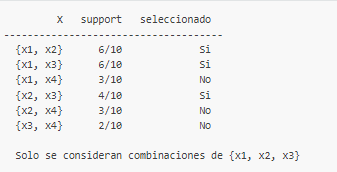

Actividad 4.— Cúales combinaciones de tres ítems pueden considerarse y cuáles cumplen con el soporte mínimo requerido?

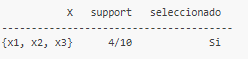

Actividad 5.— Para todas las combinaciones que cumplen con el soporte mínimo requerido, forme las correspodientes reglas y cómpute la confianza y el lift. Si la confianza mínima es del 70%, ¿cuáles reglas deben ser seleccionadas?

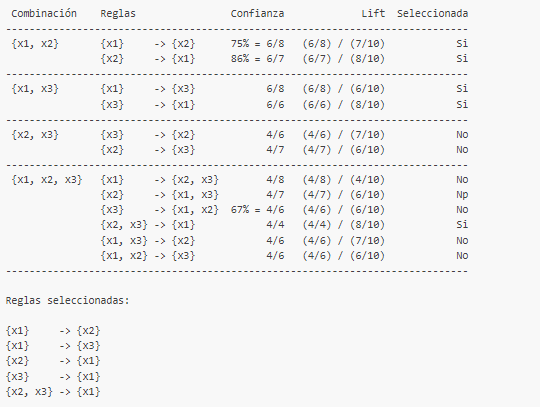

In [ ]:
print('ok_')